In [199]:
import numpy as np
import numpy.linalg as la
import scipy.sparse as sp
from scipy.sparse.linalg import cg
import matplotlib.pyplot as plt
plt.style.use('bmh')
import differentialoperatoren as dop
from differentialoperatoren import platt, stapel
%matplotlib notebook

In [200]:
def VertexIndex(xi, yi, N):
    return xi + yi*N
    #i = xi + (yi-1) * (N + 1);
    #return i

def InverseVertexIndex( k, N ):
    #xi = (k-1)%(N+1) + 1
    #yi = (k-xi)/(N+1) + 1
    xi = k%N
    yi = (k-xi)//N
    return xi,yi

In [201]:
N = 100  # Anzahl Knoten
Kantenlaenge = 1
h = Kantenlaenge/(N-1)

x = np.linspace(0,Kantenlaenge,N)
y = np.linspace(0,Kantenlaenge,N)
X,Y = np.meshgrid(x,y)

<IPython.core.display.Javascript object>


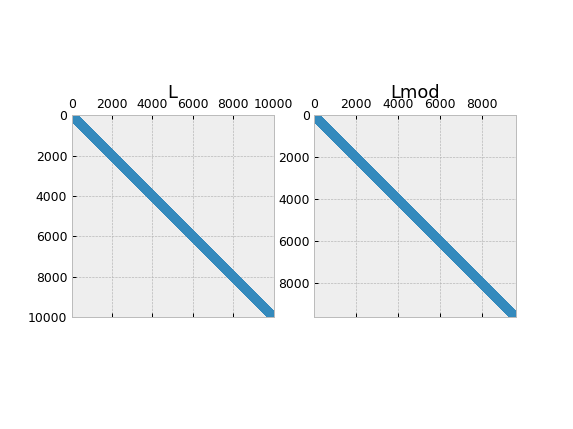

In [202]:


L = (1/h**2)*dop.LAPL(N)
#plt.spy(OP_LAPL,precision=0.01,markersize=1)
#plt.title("Laplace")
#plt.show()

Theta = np.zeros([N,N])

# Konstanten für RB
freq = 1
omega = 2*np.pi*freq
amp = 100
Randwert = lambda x,y: amp * (np.sin ( omega * x ) + np.sin ( omega * y )) + 293

Theta[0,:] = Randwert(x[0],y)
Theta[-1,:] = Randwert(x[-1],y)
Theta[:,0] = Randwert(x,y[0])
Theta[:,-1] = Randwert(x,y[-1])

if False:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax1 = fig.add_subplot(111, projection='3d')
    ax1.scatter3D(X,Y,L)
    plt.show()

fTheta = platt(Theta)
rhs = -1 * L.dot(fTheta)

#Lmod berechnen
i,j,val = sp.find(L);
nval = i.size # Anzahl der von Null verschiedenen Werte

# Indizes für die modifizierte Matrix anlegen
# ACHTUNG: Später wird nicht der gesamt index verwendet, um
#          die sparse-Matrix zu erzeugen
imod = np.zeros(nval);
jmod = np.zeros(nval);
vmod = np.zeros(nval);
nmod = 0;
for ii in range(0,nval):
    # Index xI1, ... reichen von 1..N+1
    # Zeilenindex in x- und y-Komponente unterteilen:
    xI1, yI1 = InverseVertexIndex( i[ii], N );
    xI2, yI2 = InverseVertexIndex( j[ii], N );
    # Prüfen, ob ein innerer Punkt vorliegt
    if (xI1 > 0 and xI1 < N-1 and yI1 > 0 and yI1 < N-1 and
        xI2 > 0 and xI2 < N-1 and yI2 > 0 and yI2 < N-1):
        #print("inner: yes ")
        imod[nmod] = VertexIndex(xI1, yI1 - 1, N - 2) - 1
        jmod[nmod] = VertexIndex(xI2, yI2 - 1, N - 2) - 1 
        vmod[nmod] = val[ii]
        nmod = nmod + 1

Lmod = sp.coo_matrix((vmod[0:nmod], (imod[0:nmod], jmod[0:nmod])))

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.spy(L,markersize=1)
ax1.set_title("L")
ax2.spy(Lmod,markersize=1)
ax2.set_title("Lmod")
plt.show()
#la.cholesky(L.todense())

rhsNew = np.zeros((N-2)*(N-2))
#Rechte Seite des Gleichungssystems muss ebenfalls angepasst werden:
for i in range(1,N-1):                                   # Schleife über innere Punkte
    for j in range(1,N-1):                                # Schleife über innere Punkte
        rowOld = VertexIndex(   i,   j,   N ); # Index des Punktes in
                                               # der originalen Matrix
        rowNew = VertexIndex( i-1, j-1, N-2 ); # Index des Punktes in
                                               # der neuen Matrix
        rhsNew[rowNew] = rhs[rowOld]          # Rechte Seite permutieren

        
Thetamod, info = cg(A=Lmod,b=rhsNew)

<IPython.core.display.Javascript object>


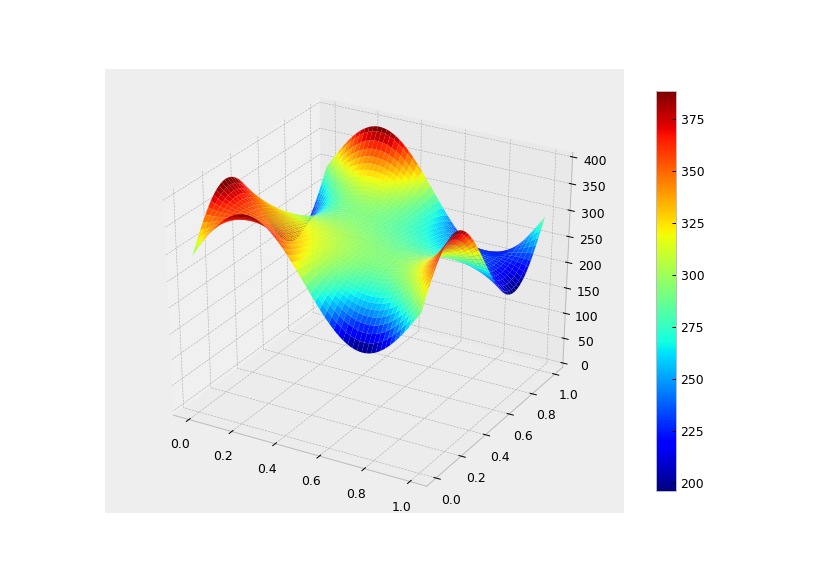

In [208]:
stapel(Thetamod)
Theta[1:N-1,1:N-1] = stapel(Thetamod)

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X,Y,Theta,cmap=cm.jet,linewidth=0)
ax.set_zbound(0,400)
fig.colorbar(surf, shrink=0.9)
plt.show()